# Imports

In [1]:
import numpy as np
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import ImageDraw, ImageFont
from PIL import Image as pImage
from IPython.display import Image
%matplotlib inline

# Pipeline step by step

## Camera Calibration

In [2]:
def camera_calib(images,nx,ny,show=False):
    '''
    Given a set of chessboard calibration images, their number of rows and columns, return
    a transformation matrix and distance coefficients for correcting radial and tangential distortion.
    Uses openCV functions to find the corners, draw them, and calibrate the camera.
    
    inputs:
        - images: chessboard calibration images
        - nx: number of rows
        - ny: number of columns
        - show: plot the resulting found corners
    outputs:
        - ret: returns true on success
        - mtx: camera transformation matrix
        - dist: distortion coefficents
        - rvecs: rotation vectors
        - tvecs: translation vectors
    '''
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            if show:
                write_name = 'output_images/corners_found'+str(idx)+'.jpg'
                cv2.imwrite(write_name, img)
                plt.imshow(img)
                plt.title(str(idx+1)+'.jpg')
                plt.show()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,
                                        imgpoints, gray.shape[::-1], None, None)
    return ret, mtx, dist, rvecs, tvecs

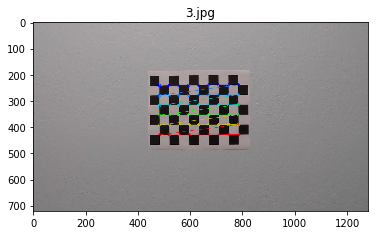

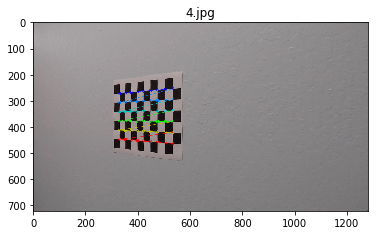

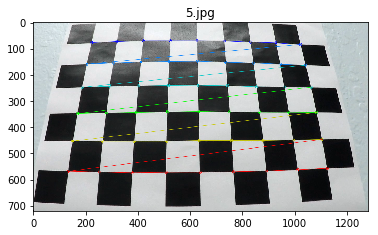

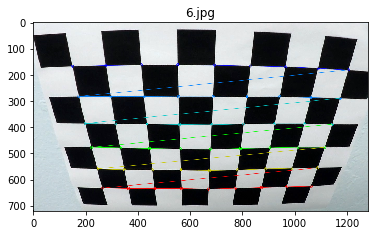

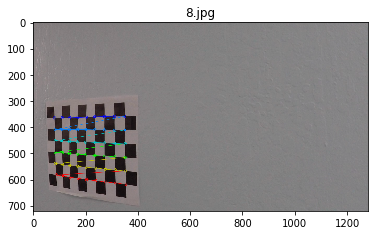

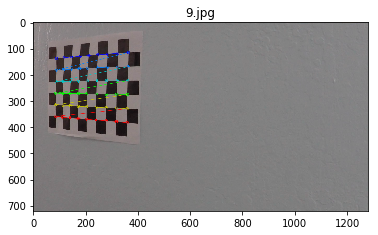

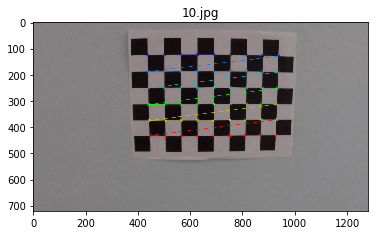

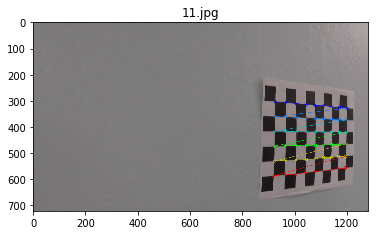

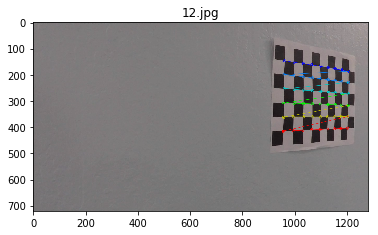

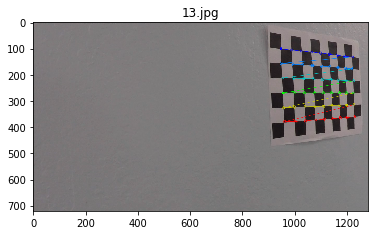

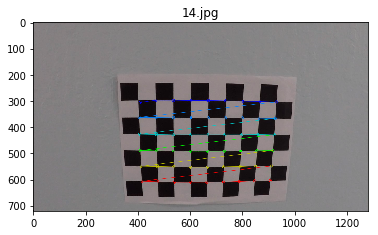

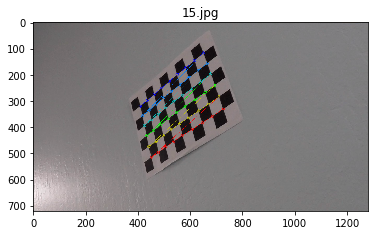

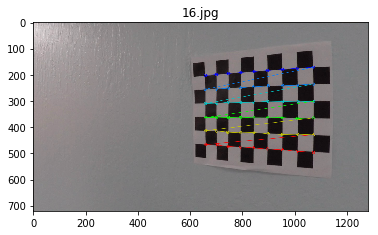

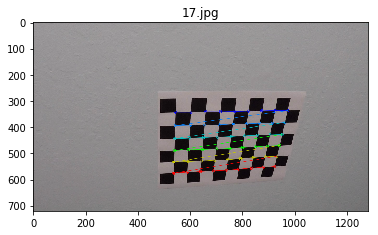

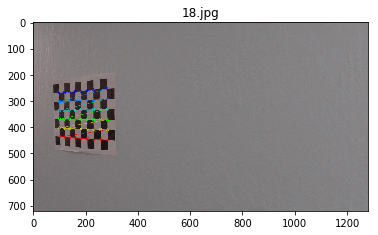

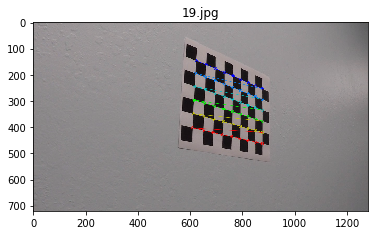

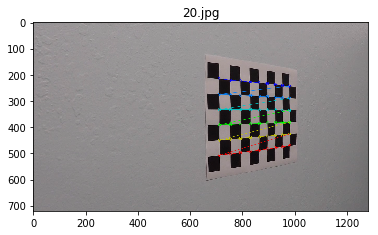

In [3]:
nx = 9
ny = 6

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')
# Get transformation matrix and distance with openCV
ret, mtx, dist, rvecs, tvecs = camera_calib(images,nx,ny,show=True)

## Undistort the image

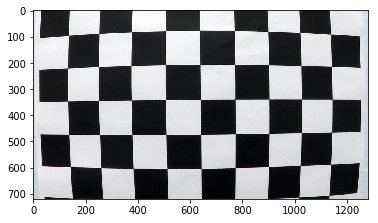

In [4]:
# test with calibration image
cal_img = cv2.imread('camera_cal/calibration1.jpg')
plt.imshow(cal_img)

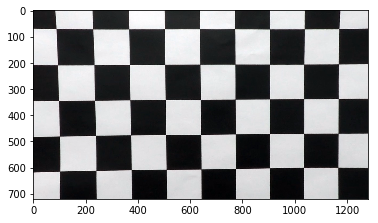

In [5]:
undist_cal = cv2.undistort(cal_img, mtx, dist, None, mtx)
plt.imshow(undist_cal)

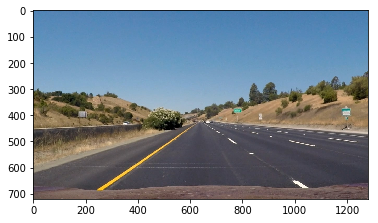

In [6]:
# Read original road image
image = cv2.imread('test_images/straight_lines1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

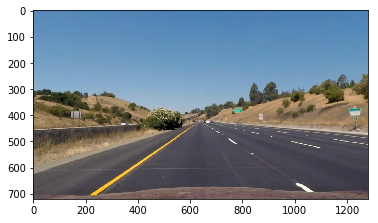

In [7]:
# Correct distortion
undist = cv2.undistort(image, mtx, dist, None, mtx)
plt.imshow(undist)

## Color Filters

In [8]:
def color_filter(undist):
    '''
    Given an road lane image, convert it to HLS colorspace. And filter the yello and white objects,
    which are typical colors for lane lines.
    inputs:
        - undist: undistorted input image
    outputs:
        - masked_color_edges: yellow and white edges mask
    '''
    # convert to HLS color space
    hls = cv2.cvtColor(undist, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]

    # White filter
    thresh = (200, 255)
    white = np.zeros_like(L)
    white[(L > thresh[0]) & (L <= thresh[1])] = 1

    #yellow filter
    hue_thresh = (14, 24) 
    sat_thresh = (110, 255)
    yellow = np.zeros_like(H)
    yellow[(H > hue_thresh[0]) & (H <= hue_thresh[1]) & (S > sat_thresh[0]) & (S <= sat_thresh[1])] = 1

    edges = np.zeros_like(white) #combined binary
    edges[(white == 1) | (yellow == 1)] = 255
    
    # Apply mask to image
    mask = np.dstack((edges,edges,edges))
    masked_color_edges = cv2.bitwise_and(undist, mask)
    return masked_color_edges

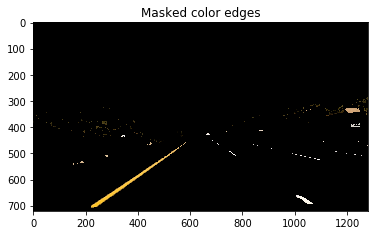

In [9]:
# filter by white and yellow colors in HLS color space
masked_color_edges = color_filter(undist)

plt.figure()
plt.title('Masked color edges')
plt.imshow(masked_color_edges)
plt.show()

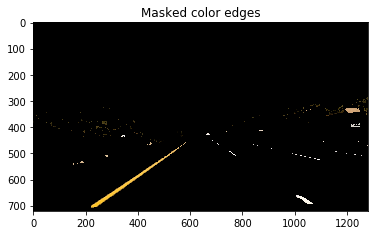

In [10]:
# filter by white and yellow colors in HLS color space
masked_color_edges = color_filter(undist)

plt.figure()
plt.title('Masked color edges')
plt.imshow(masked_color_edges)
plt.show()

## Gradient edge detection methods

In [11]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    '''
    Gradient direction threshold edge detection.
    
    Apply the following steps to img
    1) Convert to grayscale
    2) Take the gradient in x and y separately
    3) Take the absolute value of the x and y gradients
    4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    5) Create a binary mask where direction thresholds are met
    6) Return this mask as your binary_output image
    
    inputs:
        - img: input image
        - sobel_kernel: sobel kernel size for Gaussian blurring
        - thresh: min and max thresholds
    outputs:
        binary mask of detected edges as uint8 values
    '''
    
    thresh_min = thresh[0]
    thresh_max = thresh[1]

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    blur_gray = cv2.GaussianBlur(gray,(sobel_kernel, sobel_kernel),0)
    sobelx = cv2.Sobel(blur_gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(blur_gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.abs(sobelx)
    abs_sobely = np.abs(sobely)
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)

    binary_output = np.zeros_like(grad_dir)
    binary_output[(grad_dir >= thresh_min) & (grad_dir <= thresh_max)] = 255
    return np.uint8(binary_output)

def canny(img,kernel_size=5, low_threshold=80, high_threshold=240):
    '''
    Gaussian blur added before openCV Canny edge detection
    
    inputs:
        - img: input image
        - kernel_size: kernel size for gaussian blurring
        - low_threshold
        - high_threshold
    outputs:
        binary mask of detected edges
    '''
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
    canny_edges =  cv2.Canny(blur_gray, low_threshold, high_threshold)
    return canny_edges

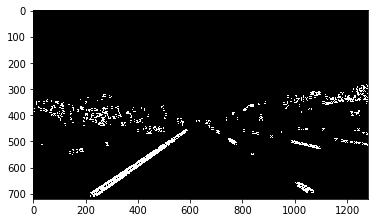

In [12]:
# apply gradient direction threshold method
dir_binary = dir_threshold(masked_color_edges, sobel_kernel=5, thresh=(0.8, 1.5)) #masked_color_edges
plt.imshow(dir_binary, cmap='Greys_r')
plt.show()

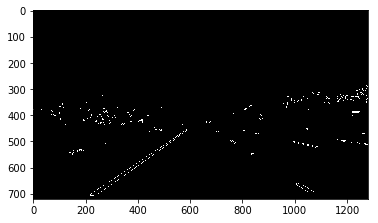

In [13]:
# apply canny edge detection
canny_edges = canny(masked_color_edges,kernel_size=9, low_threshold=25, high_threshold=50)

# Display the image
plt.figure()
plt.imshow(canny_edges, cmap='Greys_r')
plt.show()

In [14]:
# Selected gradient direction threshold edge detection
edges=dir_binary

## Region of interest mask

In [15]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from 'vertices'. The rest of the image is set to black.
    'vertices' should be a numpy array of integer points.
    
    inputs:
        - img: input image
        - vertices: polygon user-defined vertices
    outputs:
        mask within the region enclosed by the polygon
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

(720, 1280)


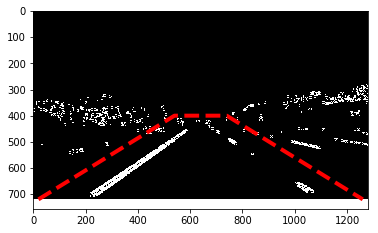

In [16]:
imshape = edges.shape
print(imshape)
# Define polygon vertices for the mask
vertices = np.array([[(20,imshape[0]),(imshape[1]//2-100, imshape[0]//2+40), 
                      (imshape[1]//2+100, imshape[0]//2+40), (imshape[1]-20,imshape[0])]],
                        dtype=np.int32)

# Filter image area with region of interest mask
masked_edges = region_of_interest(edges, vertices)

# print mask over the image
x = np.array(vertices[0][:,0])
y = np.array(vertices[0][:,1])
plt.figure()
plt.imshow(edges,cmap='gray')
plt.plot(x,y,'r--', lw=4)
plt.show()

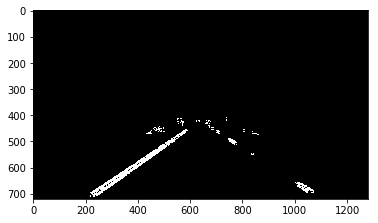

In [17]:
# Show filtered image
plt.figure()
plt.imshow(masked_edges,cmap='gray')
plt.show()

## Perspective Transform

In [18]:
# Mask vertices values as reference for source points
vertices

array([[[  20,  720],
        [ 540,  400],
        [ 740,  400],
        [1260,  720]]], dtype=int32)

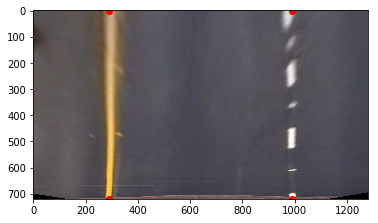

In [19]:
img = undist
img_size=(img.shape[1],img.shape[0])
xoffset = 290
yoffset = 0

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Define the destination points based on the previous conversions
# Define the initial source points based on the mask vertices and then adjust
# with the reference dots
src = np.float32([[595,450],[686,450],[1100,720],[208,720]])
dst = np.float32([[xoffset,0],[img_size[0]-1-xoffset,0],
                  [img_size[0]-1-xoffset,img_size[1]-1],
                  [xoffset,img_size[1]-1]])

# Get the perspective transform matrix and its inverse
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

# Apply the transformation matrix to the undistorted image and adjust the source points
warped = cv2.warpPerspective(undist, M, img_size)
plt.imshow(warped, cmap='gray')
plt.plot(dst[:,0],dst[:,1],'ro') #reference dots
plt.show()

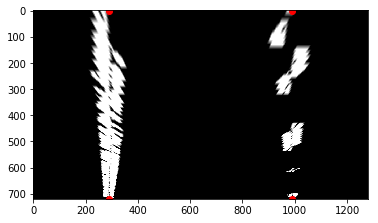

In [20]:
# Apply the transformation matrix to the masked edges
warped = cv2.warpPerspective(masked_edges, M, img_size)
plt.imshow(warped, cmap='gray') #,cmap='gray'
plt.plot(dst[:,0],dst[:,1],'ro')
plt.show()

## Calculate lines' curvature

In [21]:
def find_lane_pixels(binary_warped,plot=False):
    '''
    Finds pixels corresponding to the lanes from a binary image, by sliding windows over 
    regions where pixels are most likely to be found and storing non-zero pixels' indexes.
    
    inputs:
        binary_warped: binary warped image of the lane
        plot: true for plotting the windows and detected pixels
    outputs:
        - leftx: left lane pixels' x cooridnates
        - lefty: left lane pixels' y cooridnates
        - rightx: right lane pixels' x cooridnates
        - righty: right lane pixels' y cooridnates
        - out_img: resulting image
    '''
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0] // 2:, :], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0] // 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 140 #120
    # Set minimum number of pixels found to recenter window
    minpix = 60

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0] // nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        if plot:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img, (win_xleft_low, win_y_low),
                          (win_xleft_high, win_y_high), (0, 255, 0), 2)
            cv2.rectangle(out_img, (win_xright_low, win_y_low),
                          (win_xright_high, win_y_high), (0, 255, 0), 2)

        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

In [22]:
def look_ahead_filter(binary_warped,left_line,right_line,plot=False):
    '''
    Function to find lane pixels given found pixels in the previous frame.
    
    inputs:
        - binary warped: binary warped image of the lane
        - left_line: left line class containing previous data
        - right_line: right line class containing previous data
        - plot: true for plotting results
        
    outputs:
        - leftx: left lane pixels' x cooridnates
        - lefty: left lane pixels' y cooridnates
        - rightx: right lane pixels' x cooridnates
        - righty: right lane pixels' y cooridnates
        - out_img: resulting image
    '''
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped)) 
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 120
    # Set minimum number of pixels found to recenter window
    minpix = 30

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0] // nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_windows = np.flip(left_line.bestx)
    rightx_windows = np.flip(right_line.bestx)
    leftx_current = leftx_windows[0]
    rightx_current = rightx_windows[0]

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    #flag to represent if line.bestx is still good
    centered = True
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        if plot:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img, (win_xleft_low, win_y_low),
                          (win_xleft_high, win_y_high), (0, 255, 0), 2)
            cv2.rectangle(out_img, (win_xright_low, win_y_low),
                          (win_xright_high, win_y_high), (0, 255, 0), 2)

        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        ymax=binary_warped.shape[0]-1
        # If you found < minpix pixels, recenter next window on their histogram
        if (len(good_left_inds) < minpix) or (len(good_right_inds) < minpix):
            current_height=max(0,ymax-window_height*window)
            histogram = np.sum(binary_warped[max(current_height-100,0):current_height, :], axis=0)
            midpoint = np.int(histogram.shape[0] // 2)
            leftx_current = np.argmax(histogram[:midpoint])
            rightx_current = np.argmax(histogram[midpoint:]) + midpoint
            centered = False
        # else use previous windows' centers    
        elif (window+1 < nwindows) and centered:
            leftx_current = leftx_windows[window_height*(window+1)]
            rightx_current = rightx_windows[window_height*(window+1)]
        #else get the mean of good inds
        else:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

In [23]:
def fit_polynomial(binary_warped, left_line=None,right_line=None, plot=False):
    '''
    Function for fitting a polynomial to detected lane line pixels.
    
    inputs:
        - binary warped: binary warped image of the lane
        - left_line: left line class containing previous data
        - right_line: right line class containing previous data
        - plot: true for plotting results
    
    outputs:
        - out_img: resulting image
        - ploty: y coordinates for evaluating the polynomial
        - left_fit_cr: left fit polynomial coefficients corresponding to real world values
        - right_fit_cr: rightt fit polynomial coefficients corresponding to real world values
        - left_fitx: x values matching the polynomial on the left line
        - right_fitx: x values matching the polynomial on the right line
    
    '''
    # Find our lane pixels first
    if plot:
        plt.figure()
    if left_line and right_line:
        if (left_line.bestx is not None) and (right_line.bestx is not None):
            leftx, lefty, rightx, righty, out_img = look_ahead_filter(binary_warped,
                                                                      left_line=left_line,
                                                                      right_line=right_line,
                                                                      plot=plot)
        else:
            leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped,plot=plot)
    else:
        leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped,plot=plot)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension 30/720
    xm_per_pix = 3.7/700 # meters per pixel in x dimension 3.7/700
    
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    try:
        left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
        right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1 * ploty ** 2 + 1 * ploty
        right_fitx = 1 * ploty ** 2 + 1 * ploty
    
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    if plot:
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.imshow(out_img)
        plt.show()
    return out_img, ploty, left_fit_cr, right_fit_cr, left_fitx, right_fitx

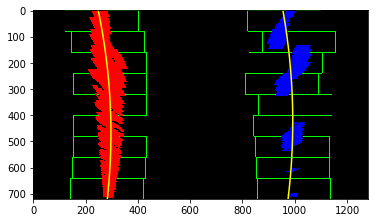

In [24]:
out_img, ploty, left_fit_cr, right_fit_cr, left_fitx, right_fitx = fit_polynomial(warped,plot=True)

In [25]:
def measure_curvature_real(ploty, left_fit_cr, right_fit_cr):
    '''
    Calculates the curvature of polynomial functions in meters.
    
    inputs:
        - ploty: y coordinates for evaluating the polynomial
        - left_fit_cr: left fit polynomial coefficients corresponding to real world values
        - right_fit_cr: rightt fit polynomial coefficients corresponding to real world values
    
    outputs:
        - left_curverad: left radius of curvature in meters 
        - right_curverad: right radius of curvature in meters 
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension 30/720
    xm_per_pix = 3.7/700 # meters per pixel in x dimension 3.7/700
    
    ploty_cr = ploty*ym_per_pix
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty_cr)

    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1+(2*left_fit_cr[0]*y_eval+left_fit_cr[1])**2)**(3/2))/np.abs(2*left_fit_cr[0])
    right_curverad = ((1+(2*right_fit_cr[0]*y_eval+right_fit_cr[1])**2)**(3/2))/np.abs(2*right_fit_cr[0])

    return left_curverad, right_curverad

In [26]:
# Get curvature in meters
left_curverad, right_curverad = measure_curvature_real(ploty, left_fit_cr, right_fit_cr)

print(left_curverad, 'm', right_curverad, 'm')

743.1123655727465 m 793.5653769537191 m


## Drawing the Lane

In [27]:
def draw_lane(warped,undist,ploty,left_fitx,right_fitx,Minv):
    '''
    Draws the lane between the left and right fitted polynomials corresponding to the lane lines.
    
    inputs:
        - warped: warped image
        - undist: undistorted road image
        - ploty: y coordinates for evaluating the polynomial
        - left_fitx: x values matching the polynomial on the left line
        - right_fitx: x values matching the polynomial on the right line
        - Minv: inverse camera transformation matrix
    
    outputs:
        undistorted image with detected lane mask
    '''
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

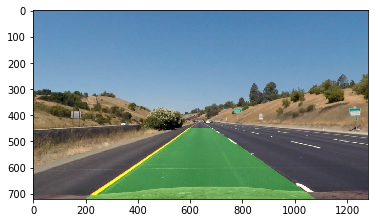

In [28]:
result = draw_lane(warped,undist,ploty,left_fitx,right_fitx,Minv)
plt.imshow(result)

# Test pipeline on test images

In [29]:
def pipeline(img, mtx, dist,img_name=None):
    '''
    Pipeline Steps:
    1. Undistort image
    2. color filters
    3. gradient method edge detection
    4. ROI mask
    4. Perspective transform
    5. Curvature calculation

    '''
    if img_name:
        print('Processing %s' % img_name)
    # Prepare image
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image = cv2.undistort(image, mtx, dist, None, mtx)
    plt.figure()
    plt.imshow(image)
    plt.title("Undistorted image")
    plt.show()
    
    # filter by white and yellow colors in HLS color space
    masked_color_edges = color_filter(image)
    plt.figure()
    plt.imshow(masked_color_edges)
    plt.title("Color filters")
    plt.show()
    
    # Detect edges with gradient
    edges = dir_threshold(masked_color_edges, sobel_kernel=5, thresh=(0.8, 1.5))
    plt.figure()
    plt.imshow(edges, cmap='Greys_r')
    plt.title("Detected edges")
    plt.show()
    
    # Region of Interest mask
    imshape = edges.shape
    vertices = np.array([[(20,imshape[0]),(imshape[1]//2-100, imshape[0]//2+40),
                        (imshape[1]//2+100, imshape[0]//2+40),
                        (imshape[1]-20,imshape[0])]],
                        dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)
    plt.figure()
    plt.imshow( masked_edges, cmap='gray')
    plt.title("ROI mask")
    plt.show()
    
    # Perspective Transform
    img = masked_edges
    img_size=(img.shape[1],img.shape[0])
    xoffset = 290
    src = np.float32([[595,450],[686,450],[1100,720],[208,720]])
    dst = np.float32([[xoffset,0],[img_size[0]-1-xoffset,0],
                      [img_size[0]-1-xoffset,img_size[1]-1],
                      [xoffset,img_size[1]-1]])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(masked_edges, M, img_size)
    plt.figure()
    plt.imshow(warped, cmap='gray')
    plt.title("Warped image")
    plt.show()
    
    # Curvature
    out_img,ploty,left_fit_cr,right_fit_cr,left_fitx,right_fitx = fit_polynomial(warped,plot=True)
    left_curverad, right_curverad = measure_curvature_real(ploty, left_fit_cr, right_fit_cr)
    print(left_curverad, 'm', right_curverad, 'm')
   
    # Draw Lane
    result = draw_lane(warped,image,ploty,left_fitx,right_fitx,Minv)
    plt.figure()
    plt.imshow(result)
    plt.title("Detected Lane")
    plt.show()

Processing test_images/test6.jpg


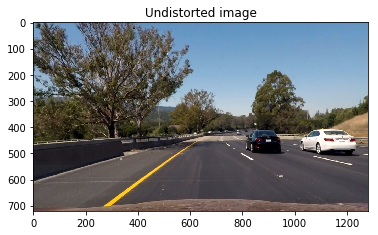

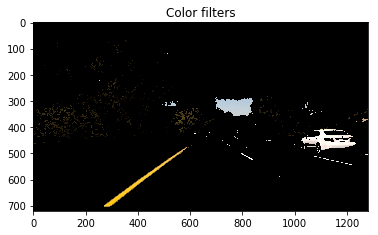

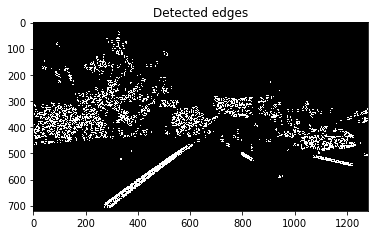

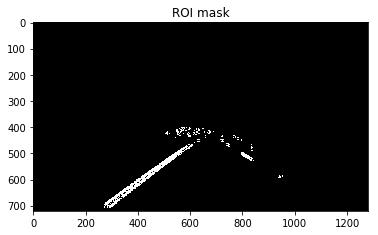

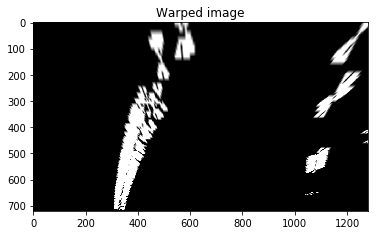

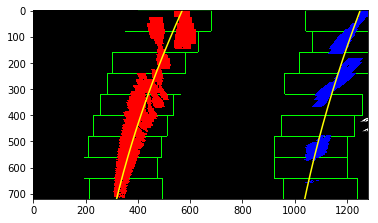

1137.2724761118677 m 1419.562253595291 m


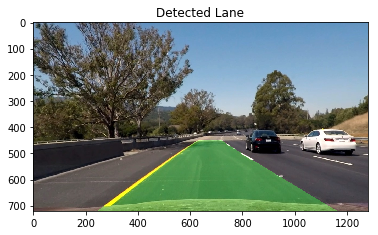

Processing test_images/test5.jpg


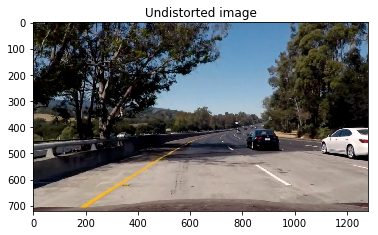

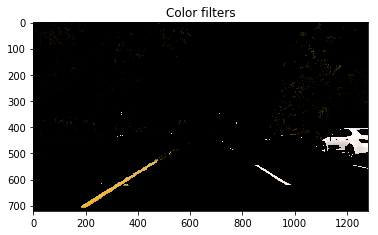

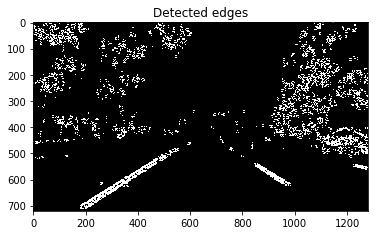

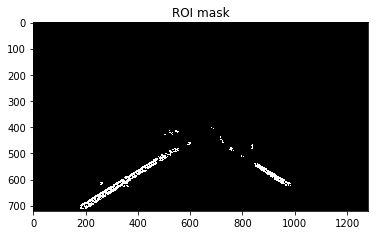

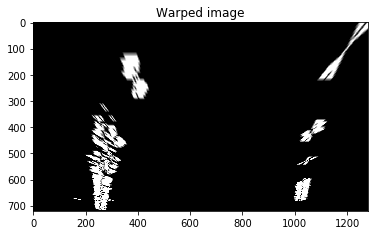

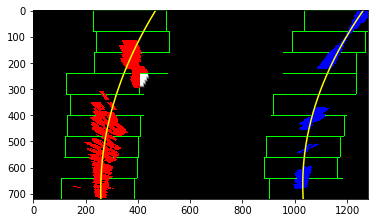

372.2135821025177 m 315.0753780183499 m


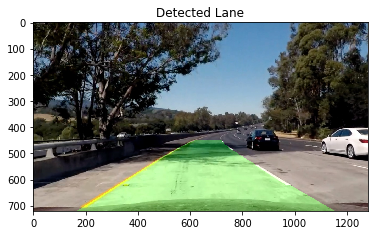

Processing test_images/test4.jpg


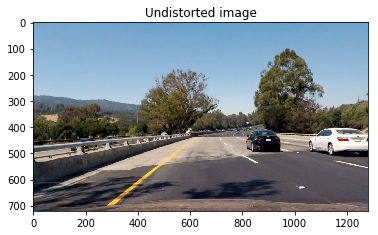

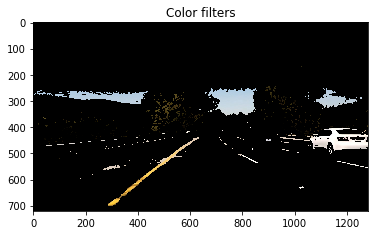

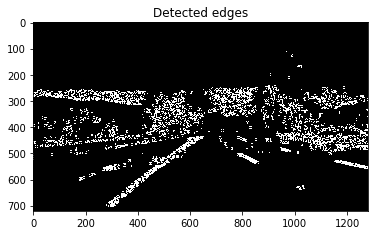

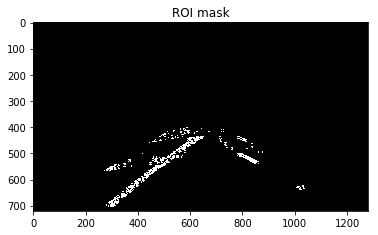

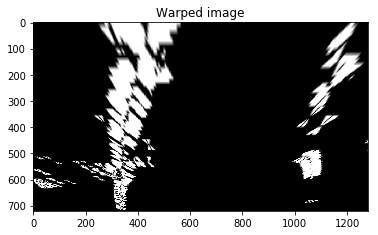

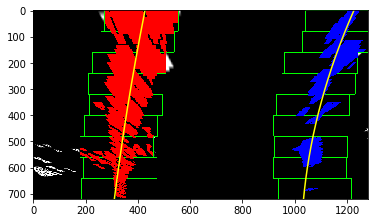

3317.903777396415 m 682.4663961212818 m


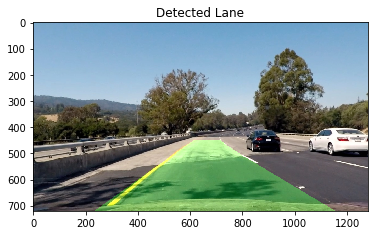

Processing test_images/test1.jpg


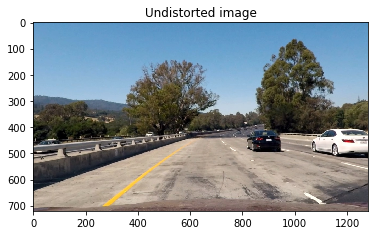

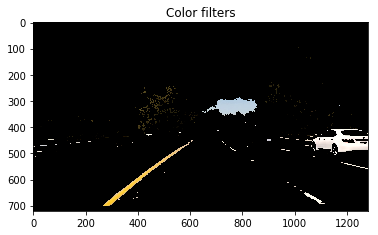

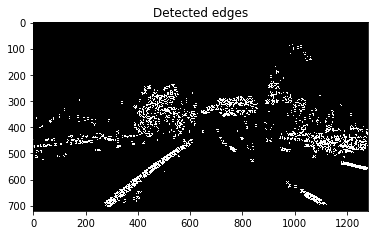

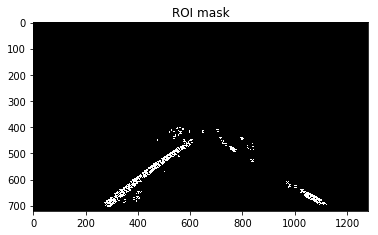

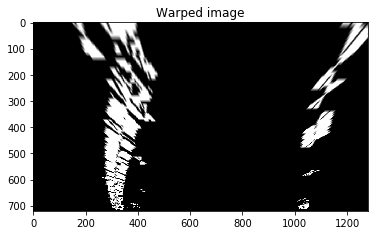

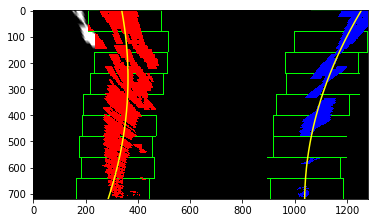

462.28594706692115 m 406.31526044439516 m


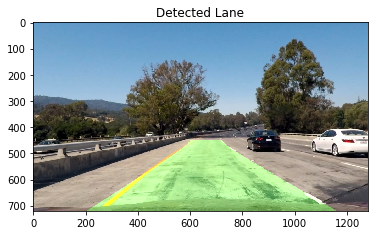

Processing test_images/test3.jpg


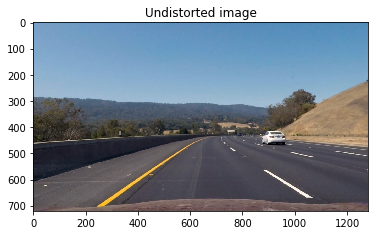

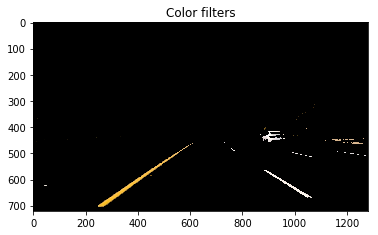

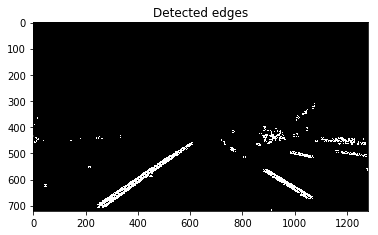

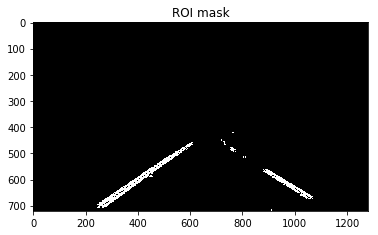

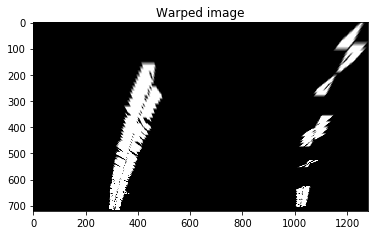

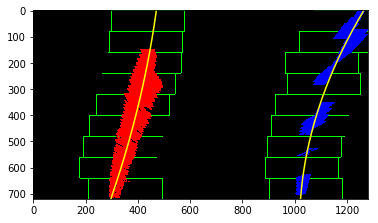

1144.1056797407034 m 454.1395035707316 m


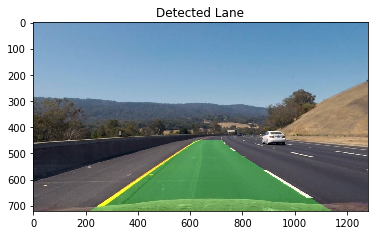

Processing test_images/test2.jpg


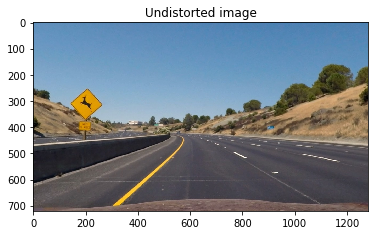

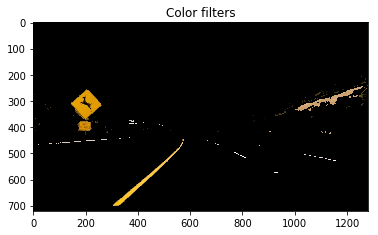

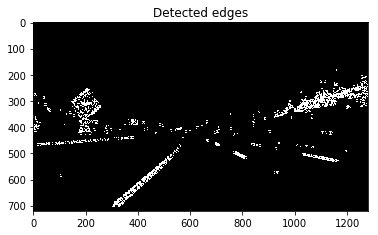

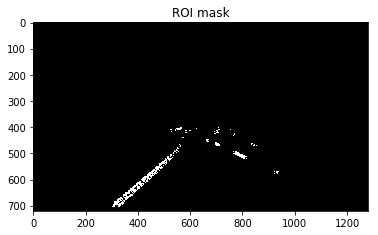

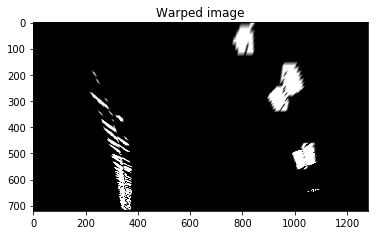

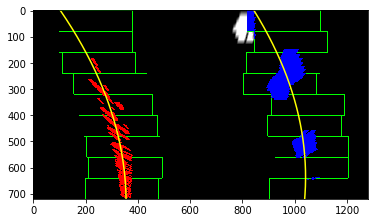

353.2418224243066 m 337.7219823890157 m


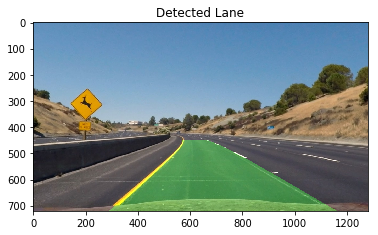

Processing test_images/straight_lines2.jpg


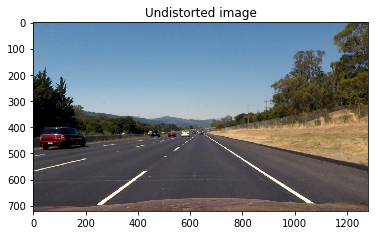

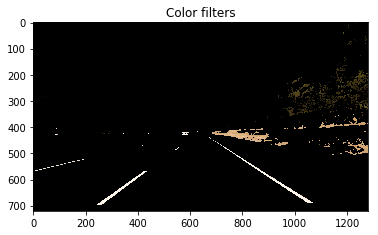

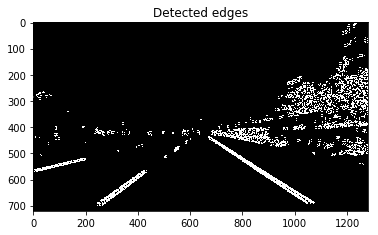

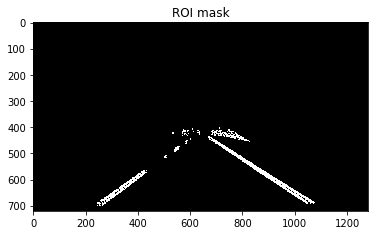

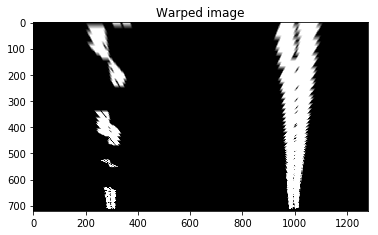

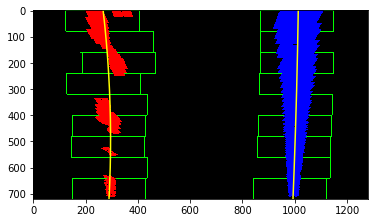

1406.2719900616207 m 9211.659365556943 m


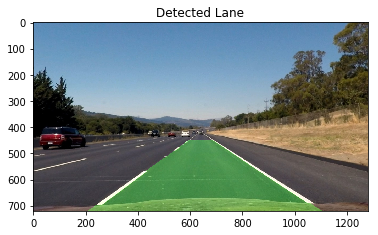

Processing test_images/straight_lines1.jpg


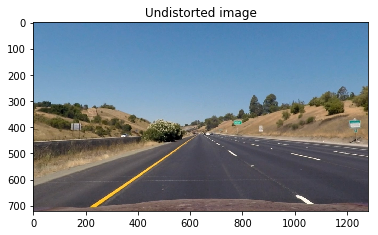

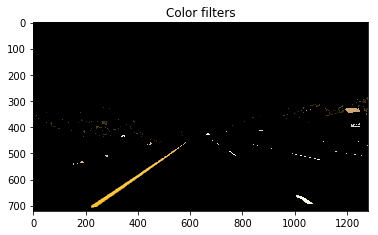

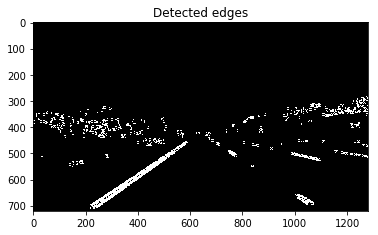

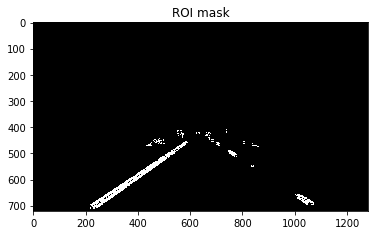

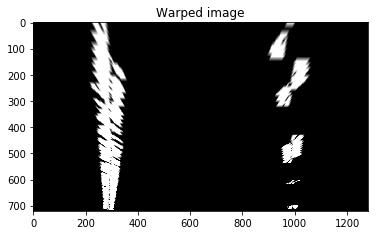

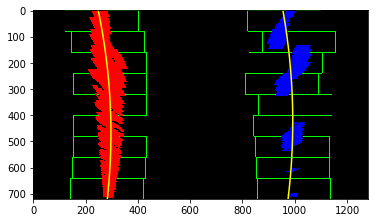

743.1123655727465 m 793.5653769537191 m


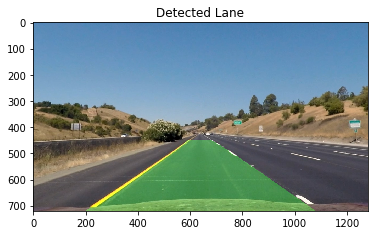

In [30]:
# Evaluate pipeline on test images
IMG_PATH = 'test_images/'

test_images = glob.glob('test_images/*.jpg')
for idx, fname in enumerate(test_images):
        img = cv2.imread(fname)
        pipeline(img, mtx, dist, fname)

# Test on Videos

In [31]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip,ImageSequenceClip
from IPython.display import HTML

## Final Pipeline for Video

In [32]:
def pipeline(img, mtx, dist,left_line,right_line,img_name=None,n=10,nmax=100,rad_max=1e4):
    
    if img_name:
        print('Processing %s' % img_name)
    # Prepare image
    # video frame is RGB already, so this time we only remove distortions
    image = cv2.undistort(img, mtx, dist, None, mtx)
    
    # filter by white and yellow colors in HLS color space
    masked_color_edges = color_filter(image)
    
    # apply gradient direction edge detector
    edges = dir_threshold(masked_color_edges, sobel_kernel=5, thresh=(0.8, 1.5))
    
    # Find Lane Lines
    imshape = edges.shape
    vertices = np.array([[(20,imshape[0]),(imshape[1]//2-100, imshape[0]//2+40),
                        (imshape[1]//2+100, imshape[0]//2+40),
                        (imshape[1]-20,imshape[0])]],
                        dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)
    try:
        # Perspective Transform
        img = masked_edges
        img_size=(img.shape[1],img.shape[0])
        xoffset = 290
        src = np.float32([[595,450],[686,450],[1100,720],[208,720]])
        dst = np.float32([[xoffset,0],[img_size[0]-1-xoffset,0],
                          [img_size[0]-1-xoffset,img_size[1]-1],
                          [xoffset,img_size[1]-1]])

        M = cv2.getPerspectiveTransform(src, dst)
        Minv = cv2.getPerspectiveTransform(dst, src)
        warped = cv2.warpPerspective(masked_edges, M, img_size)
     
        # Calculate Curvature Radius
        out_img,ploty,left_fit_cr,right_fit_cr,left_fitx,right_fitx = fit_polynomial(warped,left_line=left_line,right_line=right_line,plot=False)

        left_curverad, right_curverad = measure_curvature_real(ploty, left_fit_cr, right_fit_cr)
        
        # if no exceptions happened this far, lines were detected
        line_detected=True
        
        #  Save calculated data and calculate averages for smoothing values to display in the video if line classes are present
        if left_line and right_line:
            
            # since straight lines give yield very big radius, truncate it to a max value
            if left_curverad < rad_max:
                left_line.recent_radius.append(left_curverad)
            if right_curverad < rad_max:
                right_line.recent_radius.append(right_curverad)
            
            # Calculate distnce between lane lines and vehicle center
            current_lane_center=left_fitx[-1]+(right_fitx[-1]-left_fitx[-1])/2
            vehicle_center = img_size[0]/2
            left_lane_center_dist = (vehicle_center - left_fitx[-1])/700*3.7
            right_lane_center_dist = (right_fitx[-1] - vehicle_center)/700*3.7
            left_line.line_base_pos = left_lane_center_dist
            right_line.line_base_pos = right_lane_center_dist
            
            # save lines' x coordinates and coefficients within the fitted polynomial
            left_line.recent_xfitted.append(left_fitx)
            right_line.recent_xfitted.append(right_fitx)
            left_line.recent_fits.append(left_fit_cr)
            right_line.recent_fits.append(right_fit_cr)
            
            # average the fitted points given n last frames
            if (len(left_line.recent_xfitted) >= n):
                left_line.bestx = np.mean(np.array(left_line.recent_xfitted[-n:]),axis=0)
                right_line.bestx = np.mean(np.array(right_line.recent_xfitted[-n:]),axis=0)
                left_line.best_fit = np.mean(np.array(left_line.recent_fits[-n:]),axis=0)
                right_line.best_fit = np.mean(np.array(right_line.recent_fits[-n:]),axis=0)
            else:
                left_line.best_fit = np.mean(np.array(left_line.recent_fits),axis=0)
                right_line.best_fit = np.mean(np.array(right_line.recent_fits),axis=0)

            # average the curvature radii given n last frames
            if (len(left_line.recent_radius)>=n) and (len(right_line.recent_radius)>=n):
                left_line.radius_of_curvature = np.mean(left_line.recent_radius[-n:])
                right_line.radius_of_curvature = np.mean(right_line.recent_radius[-n:])
            else:
                left_line.radius_of_curvature = np.mean(left_line.recent_radius)
                right_line.radius_of_curvature = np.mean(right_line.recent_radius)

            # limit memory so that the algorithm doesn't slow down
            if (len(left_line.recent_radius)>=nmax) and (len(right_line.recent_radius)>=nmax):
                left_line.recent_radius = left_line.recent_radius[-n:]
                right_line.recent_radius = right_line.recent_radius[-n:]

            # limit memory so that the algorithm doesn't slow down
            if (len(left_line.recent_xfitted) >=nmax):
                left_line.recent_xfitted=left_line.recent_xfitted[-n:]
                right_line.recent_xfitted=right_line.recent_xfitted[-n:]
                left_line.recent_fits = left_line.recent_fits[-n:]
                right_line.recent_fits = right_line.recent_fits[-n:]
                
            # Draw the detected lane if we have reliable averaged measurements
            if (left_line.bestx is not None) and (right_line.bestx is not None):
                result = draw_lane(warped,image,ploty,left_line.bestx,right_line.bestx,Minv)
            else:
                result = draw_lane(warped,image,ploty,left_fitx,right_fitx,Minv)
        else:
            result = draw_lane(warped,image,ploty,left_fitx,right_fitx,Minv)

        return result

    except:
        line_detected=False
        return img


In [33]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None
        # values of the last n coefficients
        self.recent_fits = []
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.recent_radius = []
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 

## Process video

In [34]:
clip1 = VideoFileClip("./project_video.mp4").subclip(0,20)
video_output = './videos_output/test_output.mp4'

In [35]:
processed_images = []
right_line = Line()
left_line = Line()

#text format
# desired size
font = ImageFont.truetype('./fonts/roboto.ttf', size=30)

# starting position of the message
(x0,y0) = (50, 50)
(x1, y1) = (50, 90)
(x2, y2) = (700, 50)

color = 'rgb(255, 255, 255)' # white color
nframe=0
n=25 # number of frames to average measurements
lag_factor = 5 # number of frames to lag display update
message0="calibrating..." # message to display while gathering enough samples to average
message2=""

for frame in clip1.iter_frames():
    processed_image = pipeline(img=frame,
                               mtx=mtx,
                               dist=dist,
                               left_line=left_line,
                               right_line=right_line,
                               img_name=None,
                               n=n,
                               nmax=200)
    new_im = pImage.fromarray(processed_image)
    # initialise the drawing context with
    # the image object as background
    draw = ImageDraw.Draw(new_im)
    if nframe < n:
        draw.text((x0, y0), message0, fill=color, font=font)
    if nframe % lag_factor == 0:  
        message1 = 'radius of curvature:{:9.2f}m'.format(np.mean([left_line.radius_of_curvature,right_line.radius_of_curvature]))
    # draw the message on the background
    draw.text((x1, y1), message1, fill=color, font=font)
    if (left_line.line_base_pos is not None) and (left_line.line_base_pos is not None):
        if(nframe % lag_factor == 0):
            message2 = 'distance to vehicle center:\n\t-Left line: {:6.2f}m\n\t-Right line:{:6.2f}m'.format(left_line.line_base_pos,right_line.line_base_pos)
        draw.text((x2, y2), message2, fill=color, font=font)
    nframe+=1
    processed_images.append(np.array(new_im))

In [36]:
clip2=ImageSequenceClip(processed_images, fps=25)
clip2.write_videofile(video_output, audio=False)

t:   1%|▏         | 7/500 [00:00<00:07, 63.80it/s, now=None]

Moviepy - Building video ./videos_output/test_output.mp4.
Moviepy - Writing video ./videos_output/test_output.mp4



Moviepy - Done !
Moviepy - video ready ./videos_output/test_output.mp4
